# SR Inference (Inline)

Run DEM-conditioned super-resolution inference with fixed default settings, 
including chip-level and mosaic-level diagnostics against bilinear baseline.

## 0) Imports and Notebook Root

In [1]:
# Standard library + numerical stack for inference workflow.
import os
import math
import json
from pathlib import Path

# Array/data/geo stack.
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
import matplotlib.pyplot as plt

# Shared diagnostics and plotting used by training notebooks.
import t02.results as results

PROJECT_ROOT = Path("/workspace").resolve()
if PROJECT_ROOT.exists():
    os.chdir(PROJECT_ROOT)

print(f"cwd set to {Path.cwd()}")

2026-02-20 19:36:10.969625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-20 19:36:10.969674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-20 19:36:10.970516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cwd set to /workspace


## 1) Parameters (Default Behavior Preserved)

In [2]:
# Set fixed notebook parameters (no env overrides).
dem_fp = Path("_inputs/RSSHydro/dudelange/002/DEM.tif")
depth_lores_fp = Path("_inputs/RSSHydro/dudelange/032/ResultA.tif")
depth_hires_valid_fp = Path("_inputs/RSSHydro/dudelange/002/ResultA.tif")
model_fp = Path("train_outputs/4690176_0_1770580046_train_base_16/train_run/model_infer.keras")

# Keep default output behavior.
write_inference_tiff = True

# Keep default preprocessing and postprocessing behavior.
PRE_RESAMPLE_METHOD = "bilinear"
POST_RESAMPLE_METHOD = "bilinear"
ALLOWED_RESAMPLE_METHODS = (
    "nearest",
    "bilinear",
    "bicubic",
    "area",
    "lanczos3",
    "lanczos5",
)

# Use feathered inference only (default overlap derived from existing notebook behavior).
FEATHER_OVERLAP_LR = 4

# Keep dry/wet diagnostics threshold and low-depth masking defaults.
DRY_DEPTH_THRESH_M = float(results.DEFAULT_DRY_DEPTH_THRESH_M)
APPLY_LOW_DEPTH_MASK = True
LOW_DEPTH_MASK_M = float(DRY_DEPTH_THRESH_M)

# Validate static inputs early.
assert dem_fp.exists(), f"DEM file not found: {dem_fp}"
assert depth_lores_fp.exists(), f"Lo-res depth file not found: {depth_lores_fp}"
assert depth_hires_valid_fp.exists(), f"Hi-res validation depth file not found: {depth_hires_valid_fp}"
assert model_fp.exists(), f"Model file not found: {model_fp}"
assert PRE_RESAMPLE_METHOD in ALLOWED_RESAMPLE_METHODS
assert POST_RESAMPLE_METHOD in ALLOWED_RESAMPLE_METHODS
assert FEATHER_OVERLAP_LR >= 0

print(f"DEM: {dem_fp}")
print(f"LR depth: {depth_lores_fp}")
print(f"HR valid depth: {depth_hires_valid_fp}")
print(f"Model: {model_fp}")
print(f"write_inference_tiff={int(write_inference_tiff)}")
print(f"PRE_RESAMPLE_METHOD={PRE_RESAMPLE_METHOD}, POST_RESAMPLE_METHOD={POST_RESAMPLE_METHOD}")
print(f"FEATHER_OVERLAP_LR={FEATHER_OVERLAP_LR}")
print(f"APPLY_LOW_DEPTH_MASK={int(APPLY_LOW_DEPTH_MASK)}, LOW_DEPTH_MASK_M={LOW_DEPTH_MASK_M:.6f}")

DEM: _inputs/RSSHydro/dudelange/002/DEM.tif
LR depth: _inputs/RSSHydro/dudelange/032/ResultA.tif
HR valid depth: _inputs/RSSHydro/dudelange/002/ResultA.tif
Model: train_outputs/4690176_0_1770580046_train_base_16/train_run/model_infer.keras
write_inference_tiff=1
PRE_RESAMPLE_METHOD=bilinear, POST_RESAMPLE_METHOD=bilinear
FEATHER_OVERLAP_LR=4
APPLY_LOW_DEPTH_MASK=1, LOW_DEPTH_MASK_M=0.010000


## 2) Load Weights and Training Parameters

In [3]:
# Load the exported inference model with custom-activation fallback.
try:
    model = tf.keras.models.load_model(model_fp, compile=False)
except Exception as exc:
    if "bounded_sigmoid" not in str(exc):
        raise
    from t02.train_entry.train_base import bounded_sigmoid
    model = tf.keras.models.load_model(
        model_fp,
        compile=False,
        custom_objects={
            "bounded_sigmoid": bounded_sigmoid,
            "t02>bounded_sigmoid": bounded_sigmoid,
        },
    )

model.trainable = False
print(f"Loaded model: {model_fp}")


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX 4000 Ada Generation Laptop GPU, compute capability 8.9
Loaded model: train_outputs/4690176_0_1770580046_train_base_16/train_run/model_infer.keras


In [4]:
# Load train_config.json co-located with model weights.
train_config_fp = model_fp.parent / "train_config.json"
if not train_config_fp.exists():
    raise FileNotFoundError(f"train_config.json not found at {train_config_fp}")

train_cfg = json.loads(train_config_fp.read_text())
print(f"Loaded train config from {train_config_fp}")

# Validate required config keys.
required_keys = {"upscale", "input_shape", "max_depth"}
missing_keys = sorted(required_keys.difference(train_cfg.keys()))
if missing_keys:
    raise KeyError(f"train_config missing required keys: {missing_keys}")

# Resolve geometry from train config.
SCALE = int(train_cfg["upscale"])
input_shape = train_cfg["input_shape"]
if not isinstance(input_shape, (list, tuple)) or len(input_shape) < 2:
    raise AssertionError(f"input_shape must have at least [h, w, ...]; got {input_shape}")

LR_TILE = int(input_shape[0])
lr_w = int(input_shape[1])
if LR_TILE != lr_w:
    raise AssertionError(f"input_shape must be square for tiled inference; got {input_shape}")
HR_TILE = LR_TILE * SCALE

# Resolve preprocessing parameters from train config.
MAX_DEPTH = float(train_cfg["max_depth"])
DEPTH_LOG_DENOM = float(np.log1p(MAX_DEPTH))

dem_stats_cfg = train_cfg.get("dem_stats")
if train_cfg.get("dem_pct_clip") is not None:
    DEM_PCT_CLIP = float(train_cfg["dem_pct_clip"])
elif isinstance(dem_stats_cfg, dict) and dem_stats_cfg.get("p_clip") is not None:
    DEM_PCT_CLIP = float(dem_stats_cfg["p_clip"])
else:
    raise KeyError("train_config must include dem_pct_clip or dem_stats.p_clip")

# Reuse training DEM stats when available; otherwise compute from inference raster.
DEM_REF_STATS = None
if isinstance(dem_stats_cfg, dict):
    required_dem_stats = {"p_clip", "dem_min", "dem_max"}
    if required_dem_stats.issubset(dem_stats_cfg.keys()):
        DEM_REF_STATS = {k: float(dem_stats_cfg[k]) for k in sorted(required_dem_stats)}

# Resolve labels for downstream charts.
MODEL_NAME = str(train_cfg.get("model_name") or "Model").strip()
LOSS_LABEL = str(
    train_cfg.get("loss_plot_label")
    or train_cfg.get("loss_label")
    or train_cfg.get("loss_name")
    or "Loss"
).strip()
MODEL_SERIES_LABEL = f"SR ({MODEL_NAME})"

# Guardrails for config consistency.
assert SCALE > 0, f"SCALE must be > 0; got {SCALE}"
assert LR_TILE > 0, f"LR_TILE must be > 0; got {LR_TILE}"
assert HR_TILE == LR_TILE * SCALE
assert MAX_DEPTH > 0, f"MAX_DEPTH must be > 0; got {MAX_DEPTH}"
assert 0 < DEM_PCT_CLIP <= 100
assert 0 <= FEATHER_OVERLAP_LR < LR_TILE, (
    f"FEATHER_OVERLAP_LR must be in [0, {LR_TILE}); got {FEATHER_OVERLAP_LR}"
)
assert LOW_DEPTH_MASK_M >= 0.0
assert LOW_DEPTH_MASK_M <= MAX_DEPTH

print("Resolved from train_config.json:")
print(f"  SCALE={SCALE}, LR_TILE={LR_TILE}, HR_TILE={HR_TILE}")
print(f"  MAX_DEPTH={MAX_DEPTH:.6f}, DEM_PCT_CLIP={DEM_PCT_CLIP:.6f}")
print(f"  MODEL_SERIES_LABEL={MODEL_SERIES_LABEL}")
print(f"  LOSS_LABEL={LOSS_LABEL}")
if DEM_REF_STATS is not None:
    print(f"  DEM_REF_STATS={DEM_REF_STATS}")
else:
    print("  DEM_REF_STATS=None (will compute from inference DEM)")

Loaded train config from train_outputs/4690176_0_1770580046_train_base_16/train_run/train_config.json
Resolved from train_config.json:
  SCALE=16, LR_TILE=32, HR_TILE=512
  MAX_DEPTH=5.000000, DEM_PCT_CLIP=95.000000
  MODEL_SERIES_LABEL=SR (ResUNet_DEM_16)
  LOSS_LABEL=MAE
  DEM_REF_STATS=None (will compute from inference DEM)


## 3) Load and Validate Raw Rasters

In [5]:
# Open rasters and enforce grid compatibility checks before preprocessing.
with (
    rasterio.open(dem_fp) as dem_src,
    rasterio.open(depth_lores_fp) as lr_src,
    rasterio.open(depth_hires_valid_fp) as hr_src,
):
    # Ensure CRS consistency for all sources.
    if dem_src.crs != hr_src.crs or lr_src.crs != hr_src.crs:
        raise AssertionError("CRS mismatch between rasters")

    # Ensure bounds consistency for all sources.
    dem_bounds = tuple(float(v) for v in dem_src.bounds)
    lr_bounds = tuple(float(v) for v in lr_src.bounds)
    hr_bounds = tuple(float(v) for v in hr_src.bounds)
    if not all(np.isclose(a, b, atol=1e-6) for a, b in zip(dem_bounds, hr_bounds)):
        raise AssertionError(f"DEM bounds {dem_bounds} != HR bounds {hr_bounds}")
    if not all(np.isclose(a, b, atol=1e-6) for a, b in zip(lr_bounds, hr_bounds)):
        raise AssertionError(f"LR bounds {lr_bounds} != HR bounds {hr_bounds}")

    # Ensure square pixels in each raster.
    if not np.isclose(abs(dem_src.res[0]), abs(dem_src.res[1])):
        raise AssertionError(f"DEM pixels are not square: res={dem_src.res}")
    if not np.isclose(abs(lr_src.res[0]), abs(lr_src.res[1])):
        raise AssertionError(f"LR pixels are not square: res={lr_src.res}")
    if not np.isclose(abs(hr_src.res[0]), abs(hr_src.res[1])):
        raise AssertionError(f"HR pixels are not square: res={hr_src.res}")

    # Read masked arrays first so nodata issues are explicit.
    dem_read = dem_src.read(1, masked=True)
    lr_read = lr_src.read(1, masked=True)
    hr_read = hr_src.read(1, masked=True)

    # Reject nodata/masked values and NaNs.
    if np.ma.isMaskedArray(dem_read) and np.any(dem_read.mask):
        raise AssertionError("DEM contains nodata/masked values")
    if np.ma.isMaskedArray(lr_read) and np.any(lr_read.mask):
        raise AssertionError("LR depth contains nodata/masked values")
    if np.ma.isMaskedArray(hr_read) and np.any(hr_read.mask):
        raise AssertionError("HR depth contains nodata/masked values")

    dem_raw = np.asarray(dem_read, dtype=np.float32)
    lr_raw = np.asarray(lr_read, dtype=np.float32)
    hr_raw = np.asarray(hr_read, dtype=np.float32)

    if np.isnan(dem_raw).any() or np.isnan(lr_raw).any() or np.isnan(hr_raw).any():
        raise AssertionError("Input rasters contain NaNs")

    # Keep original profiles for export and geometry reporting.
    dem_profile = dem_src.profile.copy()
    lr_profile = lr_src.profile.copy()
    hr_profile = hr_src.profile.copy()

    dem_res = (abs(float(dem_src.res[0])), abs(float(dem_src.res[1])))
    lr_res_raw = (abs(float(lr_src.res[0])), abs(float(lr_src.res[1])))
    hr_res = (abs(float(hr_src.res[0])), abs(float(hr_src.res[1])))

# Apply basic value-range checks used by the original notebook.
if np.min(lr_raw) < 0 or np.min(hr_raw) < 0:
    raise AssertionError("Depth rasters contain negative values")
if np.max(lr_raw) > 15 or np.max(hr_raw) > 15:
    raise AssertionError("Depth rasters exceed 15m max depth")
if np.min(dem_raw) < 0 or np.max(dem_raw) > 5000:
    raise AssertionError("DEM raster outside expected range [0, 5000]")

# Report raw geometry and model-scale compatibility.
raw_shape_scale = (hr_raw.shape[0] / lr_raw.shape[0], hr_raw.shape[1] / lr_raw.shape[1])
raw_res_scale = (lr_res_raw[0] / hr_res[0], lr_res_raw[1] / hr_res[1])
print(f"Raw shapes HR/LR: {hr_raw.shape} / {lr_raw.shape}")
print(
    "Raw resolutions DEM/LR/HR: "
    f"DEM=({dem_res[0]:.6g}, {dem_res[1]:.6g}) "
    f"LR=({lr_res_raw[0]:.6g}, {lr_res_raw[1]:.6g}) "
    f"HR=({hr_res[0]:.6g}, {hr_res[1]:.6g})"
)
print(
    f"Raw HR:LR scale from shape (h,w)=({raw_shape_scale[0]:.2f}, {raw_shape_scale[1]:.2f}), "
    f"from resolution (x,y)=({raw_res_scale[0]:.2f}, {raw_res_scale[1]:.2f})"
)

if not np.isclose(raw_res_scale[0], SCALE) or not np.isclose(raw_res_scale[1], SCALE):
    print(
        f"WARNING: LR/HR resolution ratio (x,y)=({raw_res_scale[0]:.2f}, {raw_res_scale[1]:.2f}) != SCALE={SCALE}."
    )
    print("         HR depth and DEM will be resampled to match model scale.")

Raw shapes HR/LR: (2030, 2090) / (203, 209)
Raw resolutions DEM/LR/HR: DEM=(3, 3) LR=(30, 30) HR=(3, 3)
Raw HR:LR scale from shape (h,w)=(10.00, 10.00), from resolution (x,y)=(10.00, 10.00)
         HR depth and DEM will be resampled to match model scale.


## 4) Plot Raw Rasters

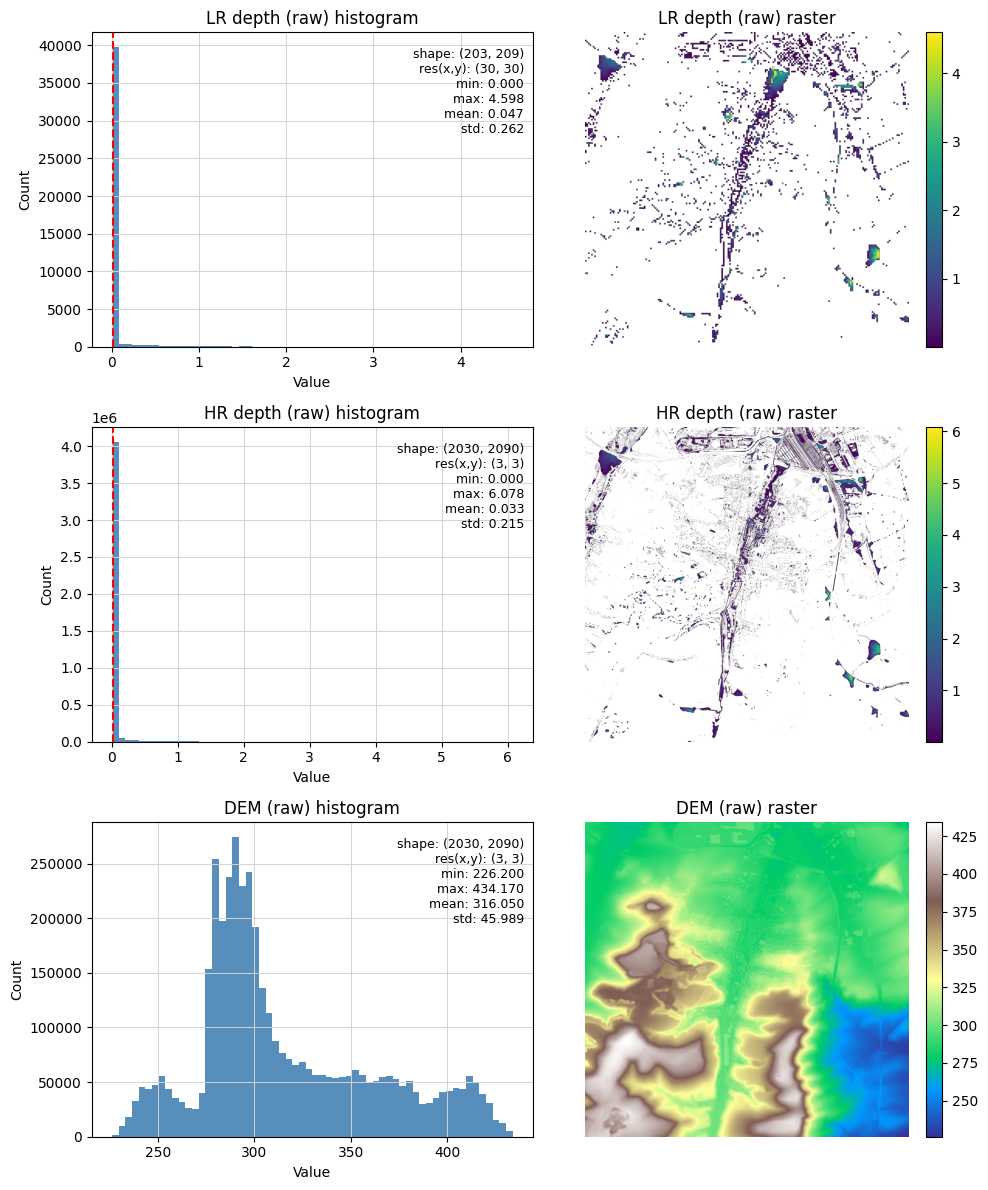

In [6]:
# Plot histograms + rasters for raw LR depth, raw HR depth, and raw DEM.
plot_specs_raw = [
    ("LR depth (raw)", lr_raw, "viridis", True, DRY_DEPTH_THRESH_M, lr_res_raw),
    ("HR depth (raw)", hr_raw, "viridis", True, DRY_DEPTH_THRESH_M, hr_res),
    ("DEM (raw)", dem_raw, "terrain", False, None, dem_res),
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for row_idx, (title, arr, cmap, use_dry_mask, dry_thresh, res_xy) in enumerate(plot_specs_raw):
    arr = np.asarray(arr, dtype=np.float32)
    vals = arr[np.isfinite(arr)]

    ax_hist = axes[row_idx, 0]
    ax_raster = axes[row_idx, 1]

    ax_hist.hist(vals, bins=60, color="steelblue", alpha=0.9)
    if use_dry_mask:
        ax_hist.axvline(dry_thresh, color="red", linestyle="--", linewidth=1.5)
    ax_hist.set_title(f"{title} histogram")
    ax_hist.set_xlabel("Value")
    ax_hist.set_ylabel("Count")
    ax_hist.grid(color="lightgrey", linestyle="-", linewidth=0.7)

    ax_hist.text(
        0.98,
        0.95,
        (
            f"shape: {arr.shape}\n"
            f"res(x,y): ({res_xy[0]:.6g}, {res_xy[1]:.6g})\n"
            f"min: {vals.min():.3f}\n"
            f"max: {vals.max():.3f}\n"
            f"mean: {vals.mean():.3f}\n"
            f"std: {vals.std():.3f}"
        ),
        transform=ax_hist.transAxes,
        fontsize=9,
        verticalalignment="top",
        horizontalalignment="right",
    )

    raster_arr = np.ma.masked_where(arr < dry_thresh, arr) if use_dry_mask else arr
    im = ax_raster.imshow(raster_arr, cmap=cmap)
    ax_raster.set_title(f"{title} raster")
    ax_raster.set_axis_off()
    fig.colorbar(im, ax=ax_raster, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 5) Pre-process Rasters for Model Input

In [15]:
# Keep raw rasters for later evaluation and create model-space normalized tensors.
lr_depth_raw_m = np.asarray(lr_raw, dtype=np.float32)
hr_depth_raw_m = np.asarray(hr_raw, dtype=np.float32)
dem_raw_m = np.asarray(dem_raw, dtype=np.float32)

raw_hr_shape = tuple(int(v) for v in hr_depth_raw_m.shape)
raw_lr_shape = tuple(int(v) for v in lr_depth_raw_m.shape)

# Build model-space HR shape from raw LR and fixed SCALE.
target_hr_h = raw_lr_shape[0] * SCALE
target_hr_w = raw_lr_shape[1] * SCALE
print("Preprocessing strategy: keep LR raw; resample HR/DEM to model SCALE.")
print(f"  pre-resample method (HR/DEM->model): {PRE_RESAMPLE_METHOD}")
print(f"  post-resample method (SR->raw HR): {POST_RESAMPLE_METHOD}")
print(f"  raw LR shape/res: {raw_lr_shape} / ({lr_res_raw[0]:.6g}, {lr_res_raw[1]:.6g})")
print(f"  raw HR shape/res: {raw_hr_shape} / ({hr_res[0]:.6g}, {hr_res[1]:.6g})")
print(f"  model HR target from LR*SCALE: {(target_hr_h, target_hr_w)} (SCALE={SCALE})")


Preprocessing strategy: keep LR raw; resample HR/DEM to model SCALE.
  pre-resample method (HR/DEM->model): bilinear
  post-resample method (SR->raw HR): bilinear
  raw LR shape/res: (203, 209) / (30, 30)
  raw HR shape/res: (3248, 3344) / (3, 3)
  model HR target from LR*SCALE: (3248, 3344) (SCALE=16)


In [16]:
# Resample HR depth and DEM to model-space HR grid.
hr_tensor = tf.convert_to_tensor(hr_depth_raw_m[None, ..., None], dtype=tf.float32)
dem_tensor = tf.convert_to_tensor(dem_raw_m[None, ..., None], dtype=tf.float32)
use_antialias_pre = PRE_RESAMPLE_METHOD != "nearest"

hr_model_depth_m = tf.image.resize(
    hr_tensor,
    size=(target_hr_h, target_hr_w),
    method=PRE_RESAMPLE_METHOD,
    antialias=use_antialias_pre,
)[0, ..., 0].numpy().astype(np.float32, copy=False)

dem_model_raw_m = tf.image.resize(
    dem_tensor,
    size=(target_hr_h, target_hr_w),
    method=PRE_RESAMPLE_METHOD,
    antialias=use_antialias_pre,
)[0, ..., 0].numpy().astype(np.float32, copy=False)

# Track depth saturation and normalize only HR targets used for diagnostics/metrics.
sat_lr = float(np.mean(lr_depth_raw_m >= MAX_DEPTH))
sat_hr_raw = float(np.mean(hr_depth_raw_m >= MAX_DEPTH))
sat_hr_model = float(np.mean(hr_model_depth_m >= MAX_DEPTH))
print(
    "Depth saturation @ MAX_DEPTH: "
    f"LR(raw)={sat_lr:.2%}, HR(raw)={sat_hr_raw:.2%}, HR(model-resampled)={sat_hr_model:.2%}"
)

hr_norm_raw = np.log1p(np.clip(hr_depth_raw_m, 0.0, MAX_DEPTH)) / DEPTH_LOG_DENOM
hr_model_norm = np.log1p(np.clip(hr_model_depth_m, 0.0, MAX_DEPTH)) / DEPTH_LOG_DENOM
hr_norm_raw = np.clip(hr_norm_raw, 0.0, 1.0).astype(np.float32, copy=False)
hr_model_norm = np.clip(hr_model_norm, 0.0, 1.0).astype(np.float32, copy=False)

# DEM normalization stats are intentionally computed per tile in the inference loop.
if DEM_REF_STATS is not None:
    print("DEM_REF_STATS detected but ignored (using per-tile DEM stats).")
print(f"DEM per-tile normalization enabled with DEM_PCT_CLIP={DEM_PCT_CLIP:.4f}.")

# Keep LR on raw grid and derive model-space HR resolution.
lr_res_model = lr_res_raw
hr_res_model = (lr_res_model[0] / SCALE, lr_res_model[1] / SCALE)

assert dem_model_raw_m.shape == hr_model_depth_m.shape
assert lr_depth_raw_m.shape == raw_lr_shape
assert hr_norm_raw.shape == raw_hr_shape

# Report geometry before and after model-space alignment.
pre_shape_scale = (raw_hr_shape[0] / raw_lr_shape[0], raw_hr_shape[1] / raw_lr_shape[1])
pre_res_scale = (lr_res_raw[0] / hr_res[0], lr_res_raw[1] / hr_res[1])
post_shape_scale = (hr_model_depth_m.shape[0] / lr_depth_raw_m.shape[0], hr_model_depth_m.shape[1] / lr_depth_raw_m.shape[1])
post_res_scale = (lr_res_model[0] / hr_res_model[0], lr_res_model[1] / hr_res_model[1])

print("Pre-resample geometry (raw inputs):")
print(f"  shapes HR/LR: {raw_hr_shape} / {raw_lr_shape}")
print(f"  resolutions HR/LR: ({hr_res[0]:.6g}, {hr_res[1]:.6g}) / ({lr_res_raw[0]:.6g}, {lr_res_raw[1]:.6g})")
print(f"  scale from shape (h,w): ({pre_shape_scale[0]:.2f}, {pre_shape_scale[1]:.2f})")
print(f"  scale from resolution (x,y): ({pre_res_scale[0]:.2f}, {pre_res_scale[1]:.2f})")

print("Post-resample geometry (model input):")
print(f"  shapes HR/LR: {hr_model_depth_m.shape} / {lr_depth_raw_m.shape}")
print(f"  resolutions HR/LR: ({hr_res_model[0]:.6g}, {hr_res_model[1]:.6g}) / ({lr_res_model[0]:.6g}, {lr_res_model[1]:.6g})")
print(f"  scale from shape (h,w): ({post_shape_scale[0]:.2f}, {post_shape_scale[1]:.2f})")
print(f"  scale from resolution (x,y): ({post_res_scale[0]:.2f}, {post_res_scale[1]:.2f})")

# Set model-valid extent before tile padding.
crop_h, crop_w = hr_model_depth_m.shape
print(f"Model-space valid extent (before tiling pad): {(crop_h, crop_w)}")

# Pad HR normalized targets plus raw LR/DEM arrays to exact tile multiples.
pad_h = (int(math.ceil(crop_h / HR_TILE)) * HR_TILE) - crop_h
pad_w = (int(math.ceil(crop_w / HR_TILE)) * HR_TILE) - crop_w

hr_pad = np.pad(hr_model_norm, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0.0)
dem_pad = np.pad(dem_model_raw_m, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0.0)

lr_pad_h_target = hr_pad.shape[0] // SCALE
lr_pad_w_target = hr_pad.shape[1] // SCALE
lr_pad_h_add = lr_pad_h_target - lr_depth_raw_m.shape[0]
lr_pad_w_add = lr_pad_w_target - lr_depth_raw_m.shape[1]
assert lr_pad_h_add >= 0 and lr_pad_w_add >= 0

lr_pad = np.pad(
    lr_depth_raw_m,
    ((0, lr_pad_h_add), (0, lr_pad_w_add)),
    mode="constant",
    constant_values=0.0,
)

pad_shape_scale = (hr_pad.shape[0] / lr_pad.shape[0], hr_pad.shape[1] / lr_pad.shape[1])
print(f"Padded shapes HR/LR: {hr_pad.shape} / {lr_pad.shape}")
print(
    f"Padded HR:LR scale from shape (h,w)=({pad_shape_scale[0]:.2f}, {pad_shape_scale[1]:.2f}) (expected {SCALE})"
)


Depth saturation @ MAX_DEPTH: LR(raw)=0.00%, HR(raw)=0.00%, HR(model-resampled)=0.00%
DEM stats computed from model-space DEM: {'p_clip': 409.72169342041013, 'dem_min': 226.19998168945312, 'dem_max': 409.7216796875}
Pre-resample geometry (raw inputs):
  shapes HR/LR: (3248, 3344) / (203, 209)
  resolutions HR/LR: (3, 3) / (30, 30)
  scale from shape (h,w): (16.00, 16.00)
  scale from resolution (x,y): (10.00, 10.00)
Post-resample geometry (model input):
  shapes HR/LR: (3248, 3344) / (203, 209)
  resolutions HR/LR: (1.875, 1.875) / (30, 30)
  scale from shape (h,w): (16.00, 16.00)
  scale from resolution (x,y): (16.00, 16.00)
Model-space valid extent (before tiling pad): (3248, 3344)
Padded shapes HR/LR: (3584, 3584) / (224, 224)
Padded HR:LR scale from shape (h,w)=(16.00, 16.00) (expected 16)


## 6) Plot Pre-processed Rasters

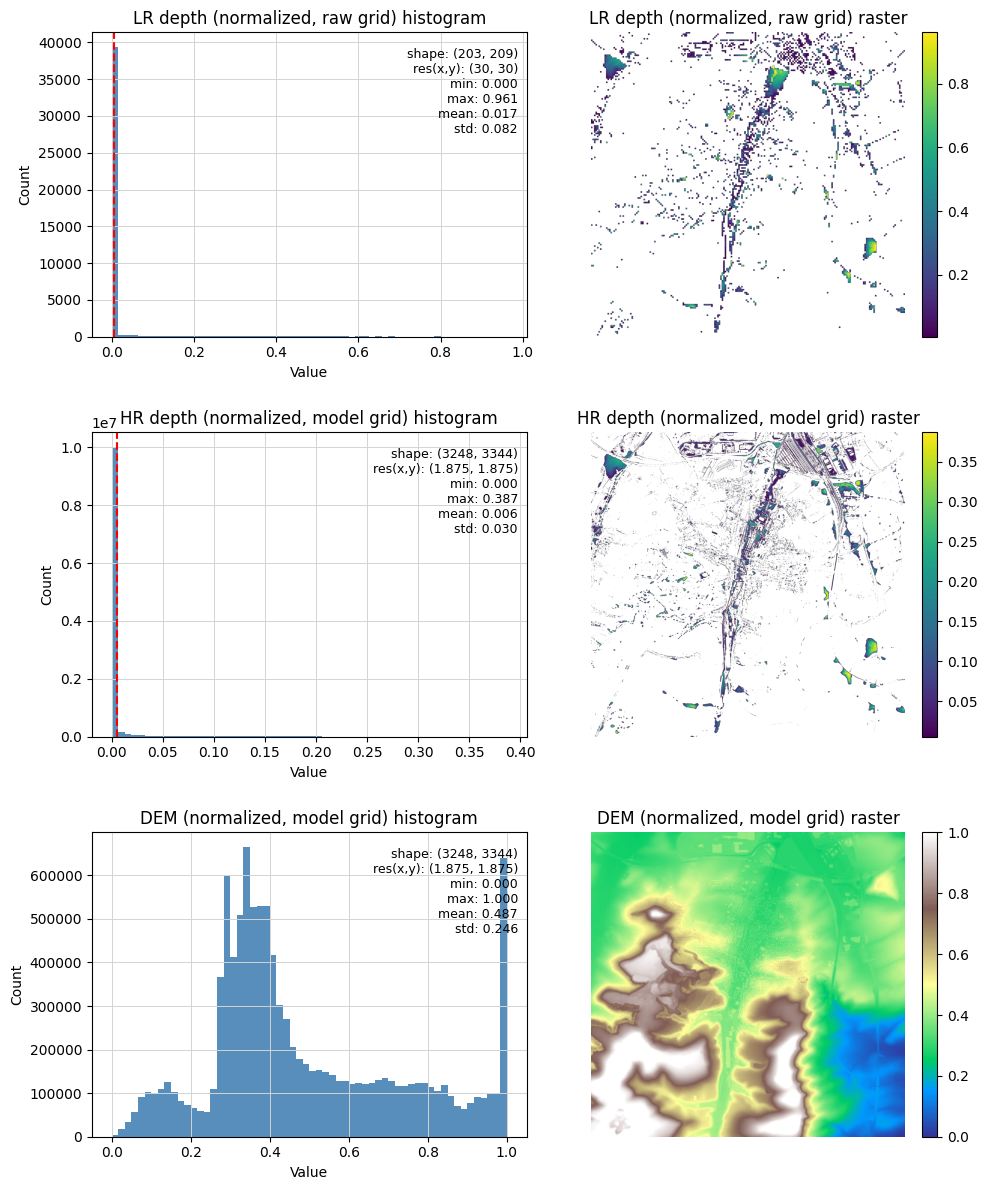

In [17]:
# Plot histograms + rasters after model-space alignment (in meter units).
plot_specs_model = [
    ("LR depth (raw grid, m)", lr_depth_raw_m, "viridis", True, DRY_DEPTH_THRESH_M, lr_res_model),
    ("HR depth (model grid, m)", hr_model_depth_m, "viridis", True, DRY_DEPTH_THRESH_M, hr_res_model),
    ("DEM (model grid, m)", dem_model_raw_m, "terrain", False, None, hr_res_model),
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for row_idx, (title, arr, cmap, use_dry_mask, dry_thresh, res_xy) in enumerate(plot_specs_model):
    arr = np.asarray(arr, dtype=np.float32)
    vals = arr[np.isfinite(arr)]

    ax_hist = axes[row_idx, 0]
    ax_raster = axes[row_idx, 1]

    ax_hist.hist(vals, bins=60, color="steelblue", alpha=0.9)
    if use_dry_mask and dry_thresh is not None:
        ax_hist.axvline(dry_thresh, color="red", linestyle="--", linewidth=1.5)
    ax_hist.set_title(f"{title} histogram")
    ax_hist.set_xlabel("Value")
    ax_hist.set_ylabel("Count")
    ax_hist.grid(color="lightgrey", linestyle="-", linewidth=0.7)

    ax_hist.text(
        0.98,
        0.95,
        (
            f"shape: {arr.shape}\n"
            f"res(x,y): ({res_xy[0]:.6g}, {res_xy[1]:.6g})\n"
            f"min: {vals.min():.3f}\n"
            f"max: {vals.max():.3f}\n"
            f"mean: {vals.mean():.3f}\n"
            f"std: {vals.std():.3f}"
        ),
        transform=ax_hist.transAxes,
        fontsize=9,
        verticalalignment="top",
        horizontalalignment="right",
    )

    raster_arr = np.ma.masked_where(arr < dry_thresh, arr) if use_dry_mask and dry_thresh is not None else arr
    im = ax_raster.imshow(raster_arr, cmap=cmap)
    ax_raster.set_title(f"{title} raster")
    ax_raster.set_axis_off()
    fig.colorbar(im, ax=ax_raster, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## 7) Windowed Inference (Feathered)

In [18]:
# Run non-overlap chip inference first to build cache and chip diagnostics arrays.
hr_pad_h, hr_pad_w = hr_pad.shape
tile_pred_cache = {}
tile_dem_stats_l = []


def normalize_inputs_per_tile(lr_tile_m, dem_tile_m):
    """Normalize one LR/DEM tile pair using only tile-local DEM stats."""
    lr_tile = np.log1p(np.clip(lr_tile_m, 0.0, MAX_DEPTH)) / DEPTH_LOG_DENOM
    lr_tile = np.clip(lr_tile, 0.0, 1.0).astype(np.float32, copy=False)

    dem_tile_nonneg = np.clip(np.asarray(dem_tile_m, dtype=np.float32), 0.0, None)
    dem_p_clip = float(np.nanpercentile(dem_tile_nonneg, DEM_PCT_CLIP))
    dem_tile_clipped = np.clip(dem_tile_nonneg, 0.0, dem_p_clip)
    dem_min = float(np.nanmin(dem_tile_clipped))
    dem_max = float(np.nanmax(dem_tile_clipped))
    dem_range = dem_max - dem_min

    if not np.isfinite(dem_p_clip) or not np.isfinite(dem_min) or not np.isfinite(dem_max):
        raise AssertionError("DEM per-tile normalization stats must be finite")

    if dem_range <= 0.0:
        dem_tile = np.zeros_like(dem_tile_clipped, dtype=np.float32)
        dem_is_flat = 1
    else:
        dem_tile = (dem_tile_clipped - dem_min) / dem_range
        dem_tile = np.clip(dem_tile, 0.0, 1.0).astype(np.float32, copy=False)
        dem_is_flat = 0

    dem_meta = {
        "dem_p_clip": dem_p_clip,
        "dem_min": dem_min,
        "dem_max": dem_max,
        "dem_range": dem_range,
        "dem_is_flat": dem_is_flat,
    }
    return lr_tile, dem_tile, dem_meta


def predict_tile_depth_m(lr_tile, dem_tile):
    """Run model on normalized inputs and return de-normalized depth tile in meters."""
    lr_tile_batched = lr_tile[..., None][None, ...].astype(np.float32, copy=False)
    dem_tile_batched = dem_tile[..., None][None, ...].astype(np.float32, copy=False)

    pred = model((lr_tile_batched, dem_tile_batched), training=False)
    pred_np = np.asarray(pred, dtype=np.float32)

    if pred_np.ndim == 4:
        if pred_np.shape[0] != 1:
            raise AssertionError(f"prediction batch dimension must be 1; got {pred_np.shape}")
        pred_np = pred_np[0]
    elif pred_np.ndim != 3:
        raise AssertionError(f"prediction rank must be 3 or 4; got {pred_np.shape}")

    if tuple(pred_np.shape) != (HR_TILE, HR_TILE, 1):
        raise AssertionError(
            f"prediction sample shape must be {(HR_TILE, HR_TILE, 1)}; got {pred_np.shape}"
        )
    if not np.all(np.isfinite(pred_np)):
        raise AssertionError("prediction must contain only finite values")

    pred_norm = np.clip(pred_np, 0.0, 1.0).astype(np.float32, copy=False)[..., 0]
    pred_depth_m = np.expm1(pred_norm * DEPTH_LOG_DENOM)
    pred_depth_m = np.clip(pred_depth_m, 0.0, MAX_DEPTH).astype(np.float32, copy=False)
    return pred_depth_m


nonoverlap_y_starts = list(range(0, hr_pad_h, HR_TILE))
nonoverlap_x_starts = list(range(0, hr_pad_w, HR_TILE))
sr_pad_nonoverlap = np.zeros_like(hr_pad, dtype=np.float32)

print(
    f"Running non-overlap per-chip inference on {len(nonoverlap_y_starts) * len(nonoverlap_x_starts)} chips..."
)

for y0 in nonoverlap_y_starts:
    for x0 in nonoverlap_x_starts:
        key = (int(y0), int(x0))

        if key not in tile_pred_cache:
            # Map HR origin to LR origin on fixed SCALE grid.
            lr_y0 = y0 // SCALE
            lr_x0 = x0 // SCALE

            # Slice aligned raw LR-depth and raw HR-DEM tiles.
            lr_tile_m = lr_pad[lr_y0 : lr_y0 + LR_TILE, lr_x0 : lr_x0 + LR_TILE]
            dem_tile_m = dem_pad[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE]

            if lr_tile_m.shape != (LR_TILE, LR_TILE):
                raise AssertionError(f"LR tile shape mismatch: {lr_tile_m.shape}")
            if dem_tile_m.shape != (HR_TILE, HR_TILE):
                raise AssertionError(f"DEM tile shape mismatch: {dem_tile_m.shape}")

            # Normalize model inputs from tile-local stats and run model.
            lr_tile, dem_tile, dem_meta = normalize_inputs_per_tile(lr_tile_m, dem_tile_m)
            tile_dem_stats_l.append(dem_meta)

            if lr_tile.min() < 0.0 or lr_tile.max() > 1.0:
                raise AssertionError("lr_tile values must be in [0,1]")
            if dem_tile.min() < 0.0 or dem_tile.max() > 1.0:
                raise AssertionError("dem_tile values must be in [0,1]")

            tile_pred_cache[key] = predict_tile_depth_m(lr_tile, dem_tile)

        sr_pad_nonoverlap[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE] = tile_pred_cache[key]

# Build valid-chip stacks for diagnostics from fully valid (non-padded) chip grid.
valid_tiles_h = crop_h // HR_TILE
valid_tiles_w = crop_w // HR_TILE
if valid_tiles_h == 0 or valid_tiles_w == 0:
    raise ValueError(f"No fully valid chips for diagnostics (crop={(crop_h, crop_w)}, HR_TILE={HR_TILE}).")

n_valid = valid_tiles_h * valid_tiles_w
lowres_chips = np.zeros((n_valid, LR_TILE, LR_TILE, 1), dtype=np.float32)
highres_chips = np.zeros((n_valid, HR_TILE, HR_TILE, 1), dtype=np.float32)
preds_chips = np.zeros((n_valid, HR_TILE, HR_TILE, 1), dtype=np.float32)
chip_coords = []

chip_idx = 0
for ty in range(valid_tiles_h):
    y0 = ty * HR_TILE
    for tx in range(valid_tiles_w):
        x0 = tx * HR_TILE

        lr_y0 = y0 // SCALE
        lr_x0 = x0 // SCALE

        lr_chip_m = lr_pad[lr_y0 : lr_y0 + LR_TILE, lr_x0 : lr_x0 + LR_TILE]
        pred_chip_m = tile_pred_cache[(y0, x0)]

        lowres_chips[chip_idx, ..., 0] = np.clip(
            np.log1p(np.clip(lr_chip_m, 0.0, MAX_DEPTH)) / DEPTH_LOG_DENOM,
            0.0,
            1.0,
        ).astype(np.float32, copy=False)
        highres_chips[chip_idx, ..., 0] = hr_pad[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE]
        preds_chips[chip_idx, ..., 0] = np.clip(
            np.log1p(np.clip(pred_chip_m, 0.0, MAX_DEPTH)) / DEPTH_LOG_DENOM,
            0.0,
            1.0,
        ).astype(np.float32, copy=False)
        chip_coords.append((y0, x0))
        chip_idx += 1

chip_coords = np.asarray(chip_coords, dtype=np.int32)
print(f"Prepared {chip_idx} valid chips ({valid_tiles_h} x {valid_tiles_w}) for diagnostics.")

# Build feather window grid with forced trailing-edge coverage.
overlap_hr = FEATHER_OVERLAP_LR * SCALE
stride_hr = HR_TILE - overlap_hr
if stride_hr <= 0:
    raise AssertionError(
        f"Feather stride must be > 0; got stride_hr={stride_hr} from FEATHER_OVERLAP_LR={FEATHER_OVERLAP_LR}"
    )

y_starts = list(range(0, max(hr_pad_h - HR_TILE + 1, 1), stride_hr))
x_starts = list(range(0, max(hr_pad_w - HR_TILE + 1, 1), stride_hr))
last_y = hr_pad_h - HR_TILE
last_x = hr_pad_w - HR_TILE
if y_starts[-1] != last_y:
    y_starts.append(last_y)
if x_starts[-1] != last_x:
    x_starts.append(last_x)

# Build symmetric 1D feather ramp for separable 2D blending.
feather_1d = np.ones(HR_TILE, dtype=np.float32)
if overlap_hr > 0:
    ramp = np.linspace(0.0, 1.0, overlap_hr + 2, dtype=np.float32)[1:-1]
    feather_1d[:overlap_hr] = ramp
    feather_1d[-overlap_hr:] = ramp[::-1]
feather_1d = np.clip(feather_1d, 1e-3, 1.0)

accum = np.zeros_like(hr_pad, dtype=np.float32)
weight_sum = np.zeros_like(hr_pad, dtype=np.float32)

print(
    f"Mosaicing with feather windows: {len(y_starts) * len(x_starts)} windows "
    f"(overlap={overlap_hr} px, stride={stride_hr} px)..."
)

for yi, y0 in enumerate(y_starts):
    for xi, x0 in enumerate(x_starts):
        key = (int(y0), int(x0))

        if key not in tile_pred_cache:
            lr_y0 = y0 // SCALE
            lr_x0 = x0 // SCALE
            lr_tile_m = lr_pad[lr_y0 : lr_y0 + LR_TILE, lr_x0 : lr_x0 + LR_TILE]
            dem_tile_m = dem_pad[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE]

            if lr_tile_m.shape != (LR_TILE, LR_TILE):
                raise AssertionError(f"LR tile shape mismatch: {lr_tile_m.shape}")
            if dem_tile_m.shape != (HR_TILE, HR_TILE):
                raise AssertionError(f"DEM tile shape mismatch: {dem_tile_m.shape}")

            lr_tile, dem_tile, dem_meta = normalize_inputs_per_tile(lr_tile_m, dem_tile_m)
            tile_dem_stats_l.append(dem_meta)
            tile_pred_cache[key] = predict_tile_depth_m(lr_tile, dem_tile)

        pred_depth_m = tile_pred_cache[key]

        # Flatten exterior feather edges so the scene boundary is not dimmed.
        wy = feather_1d.copy()
        wx = feather_1d.copy()
        if yi == 0:
            wy[:overlap_hr] = 1.0
        if yi == len(y_starts) - 1:
            wy[-overlap_hr:] = 1.0
        if xi == 0:
            wx[:overlap_hr] = 1.0
        if xi == len(x_starts) - 1:
            wx[-overlap_hr:] = 1.0

        weight = np.outer(wy, wx).astype(np.float32, copy=False)
        accum[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE] += pred_depth_m * weight
        weight_sum[y0 : y0 + HR_TILE, x0 : x0 + HR_TILE] += weight

sr_pad = np.divide(
    accum,
    np.maximum(weight_sum, 1e-6),
    out=np.zeros_like(accum),
    where=weight_sum > 0,
)
print(f"Cached predictions after feather mosaicing: {len(tile_pred_cache)}")

if tile_dem_stats_l:
    tile_dem_stats_df = pd.DataFrame(tile_dem_stats_l)
    flat_count = int(tile_dem_stats_df["dem_is_flat"].sum())
    print("Per-tile DEM normalization stats (cached tiles):")
    print(
        "  p_clip min/mean/max="
        f"{tile_dem_stats_df['dem_p_clip'].min():.4f}/"
        f"{tile_dem_stats_df['dem_p_clip'].mean():.4f}/"
        f"{tile_dem_stats_df['dem_p_clip'].max():.4f}"
    )
    print(
        "  range  min/mean/max="
        f"{tile_dem_stats_df['dem_range'].min():.4f}/"
        f"{tile_dem_stats_df['dem_range'].mean():.4f}/"
        f"{tile_dem_stats_df['dem_range'].max():.4f}, "
        f"flat tiles={flat_count:,}/{len(tile_dem_stats_df):,}"
    )

# Crop back to valid model-space extent and bound depth range.
sr_model_m = np.clip(sr_pad[:crop_h, :crop_w], 0.0, MAX_DEPTH).astype(np.float32, copy=False)
hr_model_valid = hr_pad[:crop_h, :crop_w]
print(f"Model-space SR/HR shapes: {sr_model_m.shape} / {hr_model_valid.shape}")

# Resample model-space SR depth back to raw HR grid for final evaluation.
print("Post-processing: resample model-space SR back to raw HR grid.")
print(f"  method={POST_RESAMPLE_METHOD}, target shape/res={raw_hr_shape} / ({hr_res[0]:.6g}, {hr_res[1]:.6g})")

sr_tensor = tf.convert_to_tensor(sr_model_m[None, ..., None], dtype=tf.float32)
use_antialias_post = POST_RESAMPLE_METHOD != "nearest"
sr_depth_m = tf.image.resize(
    sr_tensor,
    size=raw_hr_shape,
    method=POST_RESAMPLE_METHOD,
    antialias=use_antialias_post,
)[0, ..., 0].numpy().astype(np.float32, copy=False)
sr_depth_m = np.clip(sr_depth_m, 0.0, MAX_DEPTH)

# Apply low-depth mask in meter space (de-normalized domain).
if APPLY_LOW_DEPTH_MASK:
    low_mask = sr_depth_m < LOW_DEPTH_MASK_M
    masked_count = int(np.sum(low_mask))
    sr_depth_m = np.where(low_mask, 0.0, sr_depth_m).astype(np.float32, copy=False)
    print(
        "Applied low-depth SR mask: "
        f"threshold={LOW_DEPTH_MASK_M:.6f} m, "
        f"masked={masked_count:,}/{sr_depth_m.size:,} ({masked_count/sr_depth_m.size:.2%})"
    )

# Normalize SR back to [0, 1] for existing metric helpers.
sr = np.log1p(np.clip(sr_depth_m, 0.0, MAX_DEPTH)) / DEPTH_LOG_DENOM
sr = np.clip(sr, 0.0, 1.0).astype(np.float32, copy=False)

# Keep normalized HR target on original raw HR grid for metrics.
hr_valid = np.clip(hr_norm_raw, 0.0, 1.0).astype(np.float32, copy=False)

print(f"Post-processed SR/HR shapes: {sr.shape} / {hr_valid.shape}")


Running non-overlap per-chip inference on 49 chips...
Prepared 36 valid chips (6 x 6) for diagnostics.
Mosaicing with feather windows: 64 windows (overlap=64 px, stride=448 px)...
Cached predictions after feather mosaicing: 109
Model-space SR/HR shapes: (3248, 3344) / (3248, 3344)
Post-processing: resample model-space SR back to raw HR grid.
  method=bilinear, target shape/res=(3248, 3344) / (3, 3)
Applied low-depth SR mask: threshold=0.010000 m (0.005553 norm), masked=9,907,796/10,861,312 (91.22%)
Post-processed SR/HR shapes: (3248, 3344) / (3248, 3344)


## 8) Per-chip Performance

Chip geometry: LR chip=(32, 32), HR chip=(512, 512), scale(h,w)=(16.00, 16.00)
Per-chip summary:
{
  "baseline": {
    "CSI": 0.2644336521625519,
    "CSI_001cm": 0.2644336521625519,
    "CSI_050cm": 0.0,
    "CSI_100cm": 0.0,
    "MAE": 0.016119904816150665,
    "PSNR": 27.737504959106445,
    "RMSE": 0.051067858934402466,
    "RMSE_wet": null,
    "RMSE_wet_001cm": 0.12332958728075027,
    "RMSE_wet_050cm": null,
    "RMSE_wet_100cm": null,
    "SSIM": 0.8552564978599548
  },
  "best_epoch": {
    "CSI": 0.27459511160850525,
    "CSI_001cm": 0.27459511160850525,
    "CSI_050cm": 0.0,
    "CSI_100cm": 0.0,
    "MAE": 0.006825117394328117,
    "PSNR": 34.019412994384766,
    "RMSE": 0.023256177082657814,
    "RMSE_wet": null,
    "RMSE_wet_001cm": 0.07845866680145264,
    "RMSE_wet_050cm": null,
    "RMSE_wet_100cm": null,
    "SSIM": 0.8954101204872131
  }
}


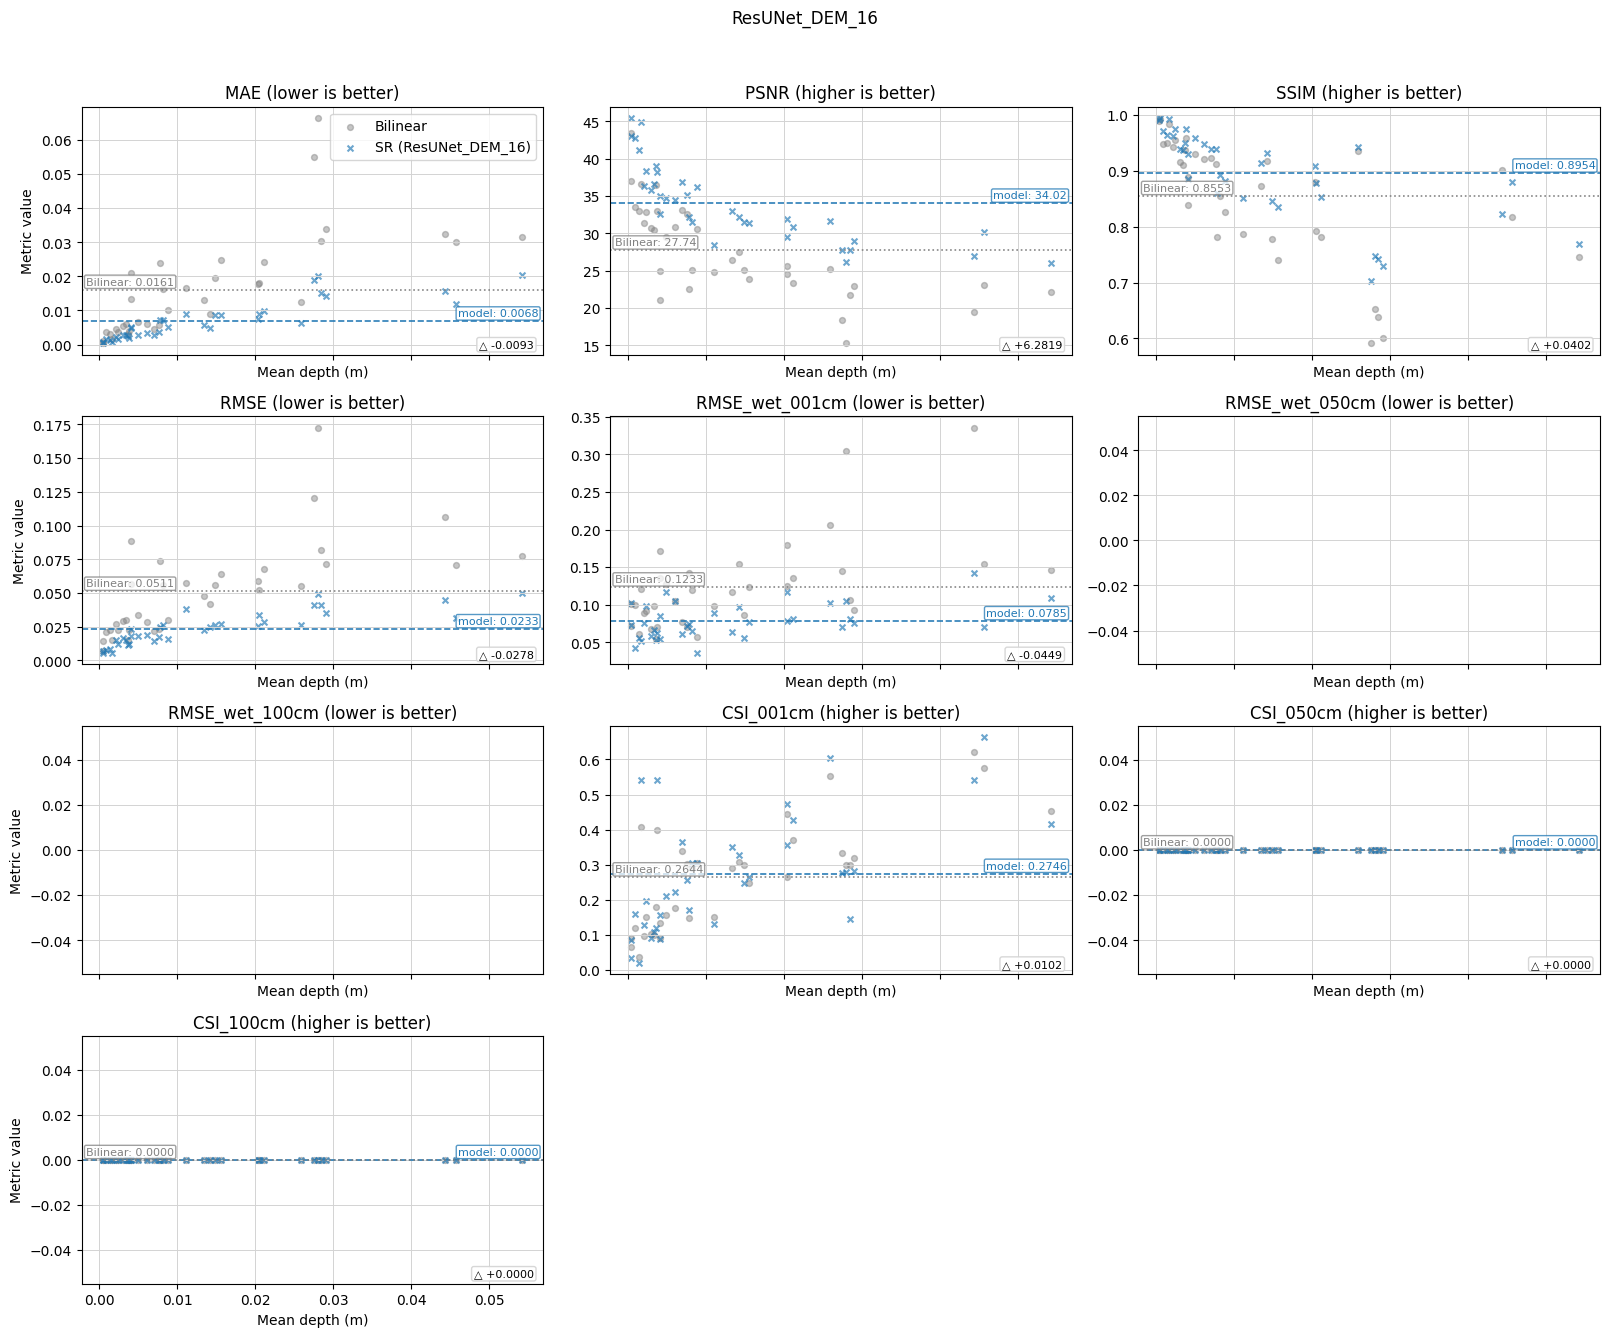

In [19]:
# Evaluate chip-level SR vs bilinear baseline metrics.
chip_shape_scale = (
    highres_chips.shape[1] / lowres_chips.shape[1],
    highres_chips.shape[2] / lowres_chips.shape[2],
)
print(
    f"Chip geometry: LR chip={lowres_chips.shape[1:3]}, HR chip={highres_chips.shape[1:3]}, "
    f"scale(h,w)=({chip_shape_scale[0]:.2f}, {chip_shape_scale[1]:.2f})"
)

chip_summary, chip_per_sample = results.evaluate_chip_arrays_vs_bilinear(
    lowres_chips=lowres_chips,
    highres_chips=highres_chips,
    preds_chips=preds_chips,
    max_depth=MAX_DEPTH,
    split_name="inference_chips",
    dry_depth_thresh_m=DRY_DEPTH_THRESH_M,
)

print("Per-chip summary:")
print(json.dumps(chip_summary, indent=2, sort_keys=True))

fig_scatter, _ = results.plot_metric_scatter_vs_mean_depth(
    chip_per_sample,
    model_label=MODEL_SERIES_LABEL,
    baseline_label="Bilinear",
    split_summary=chip_summary,
    model_name=MODEL_NAME,
    loss_plot_label=LOSS_LABEL,
)
plt.show()
plt.close(fig_scatter)

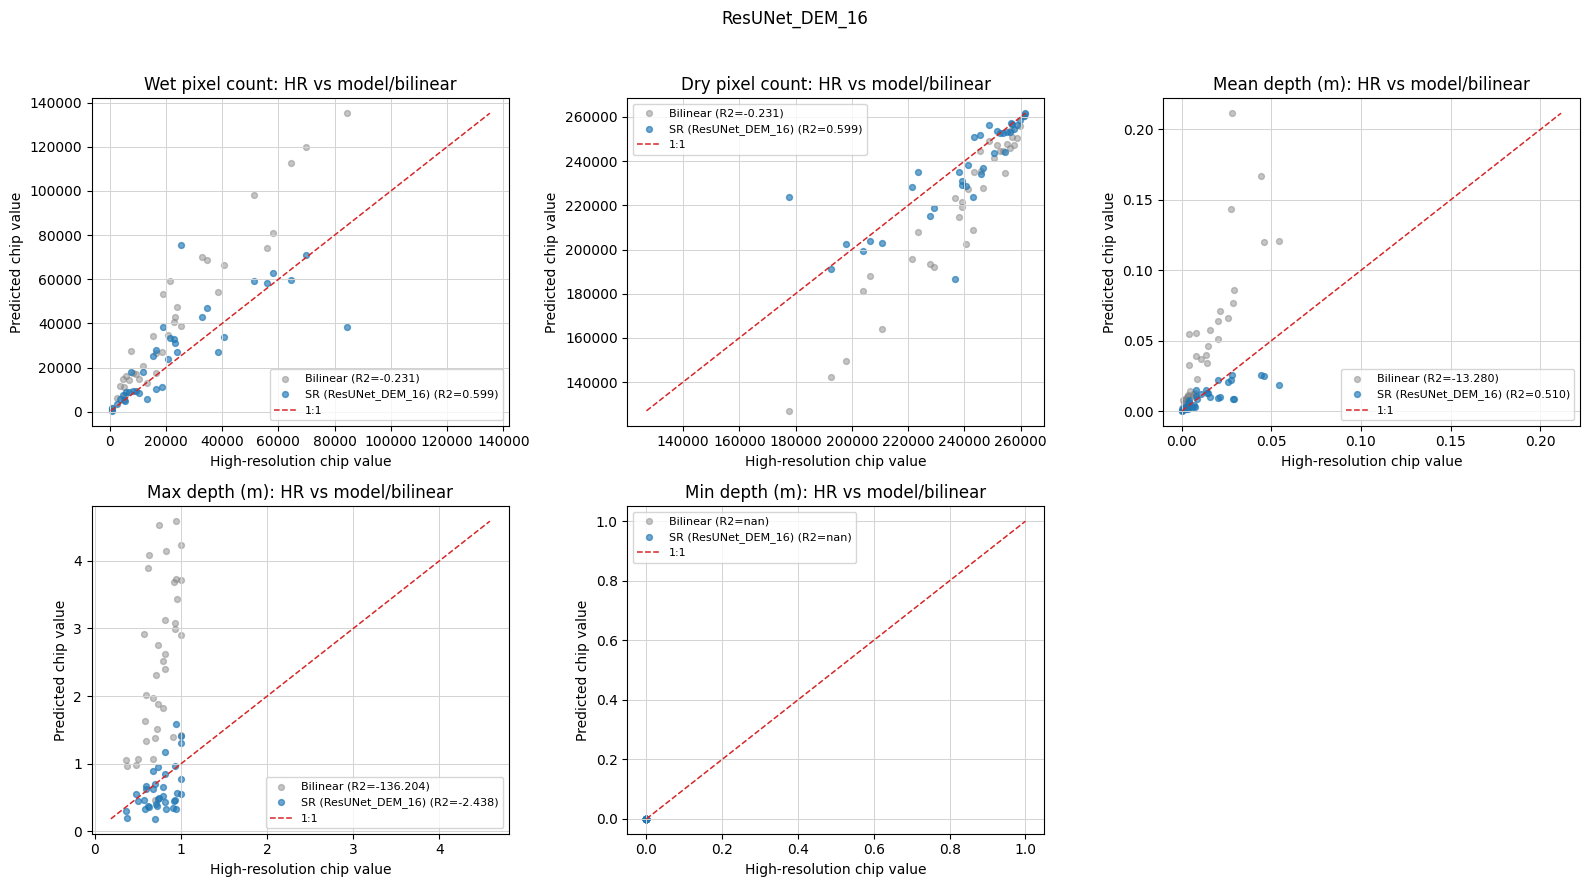

In [24]:
# Plot chip-level statistics and best/worst examples.
fig_chip_scatter, _ = results.plot_chip_stat_scatter(
    chip_per_sample,
    model_label=MODEL_SERIES_LABEL,
    baseline_label="Bilinear",
    model_name=MODEL_NAME,
)
plt.show()
 


### PLOT: chip examples

Scanned test chips: 36
Retained candidate chips in memory: 6

Worst chips (highest SR MAE):


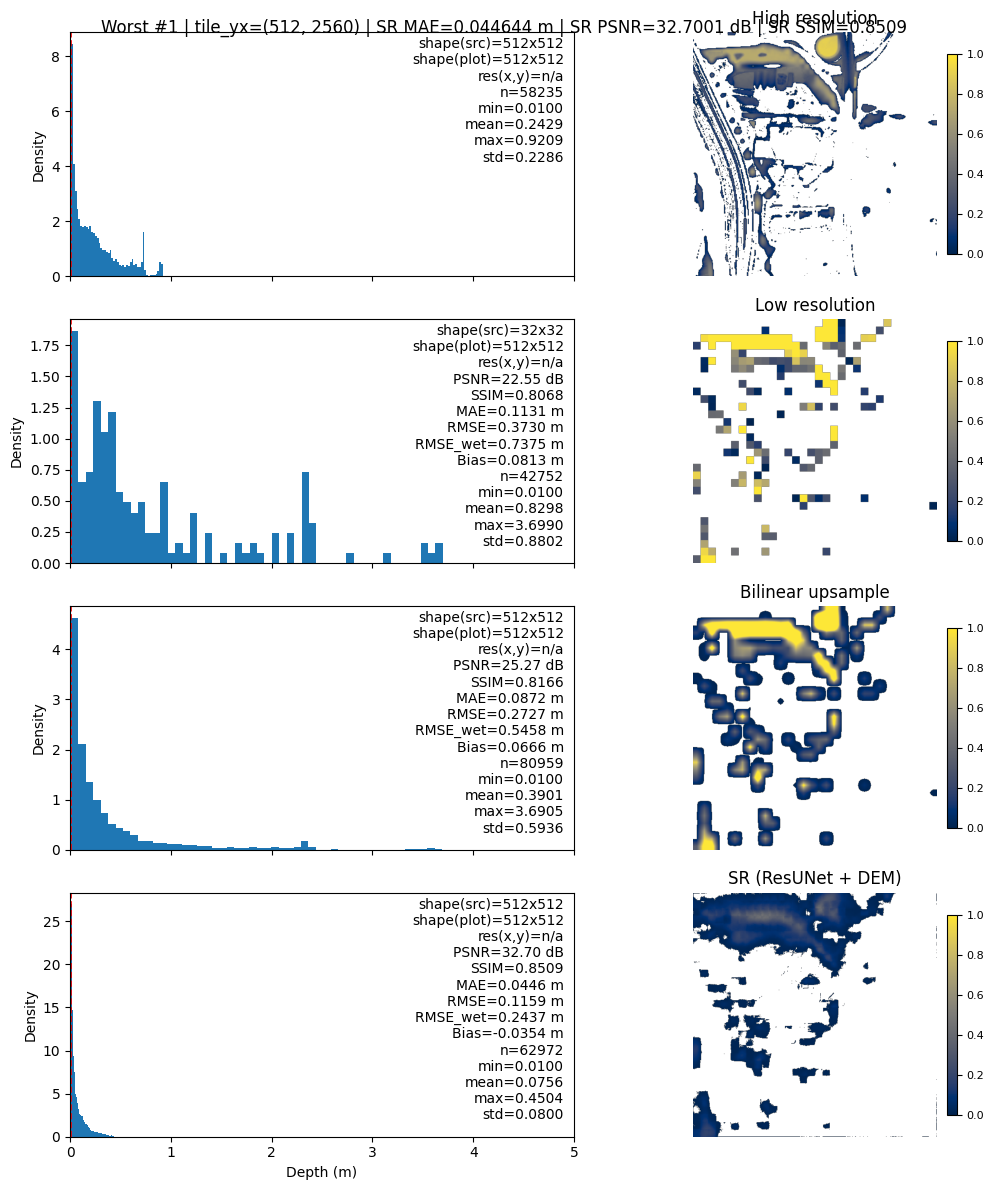

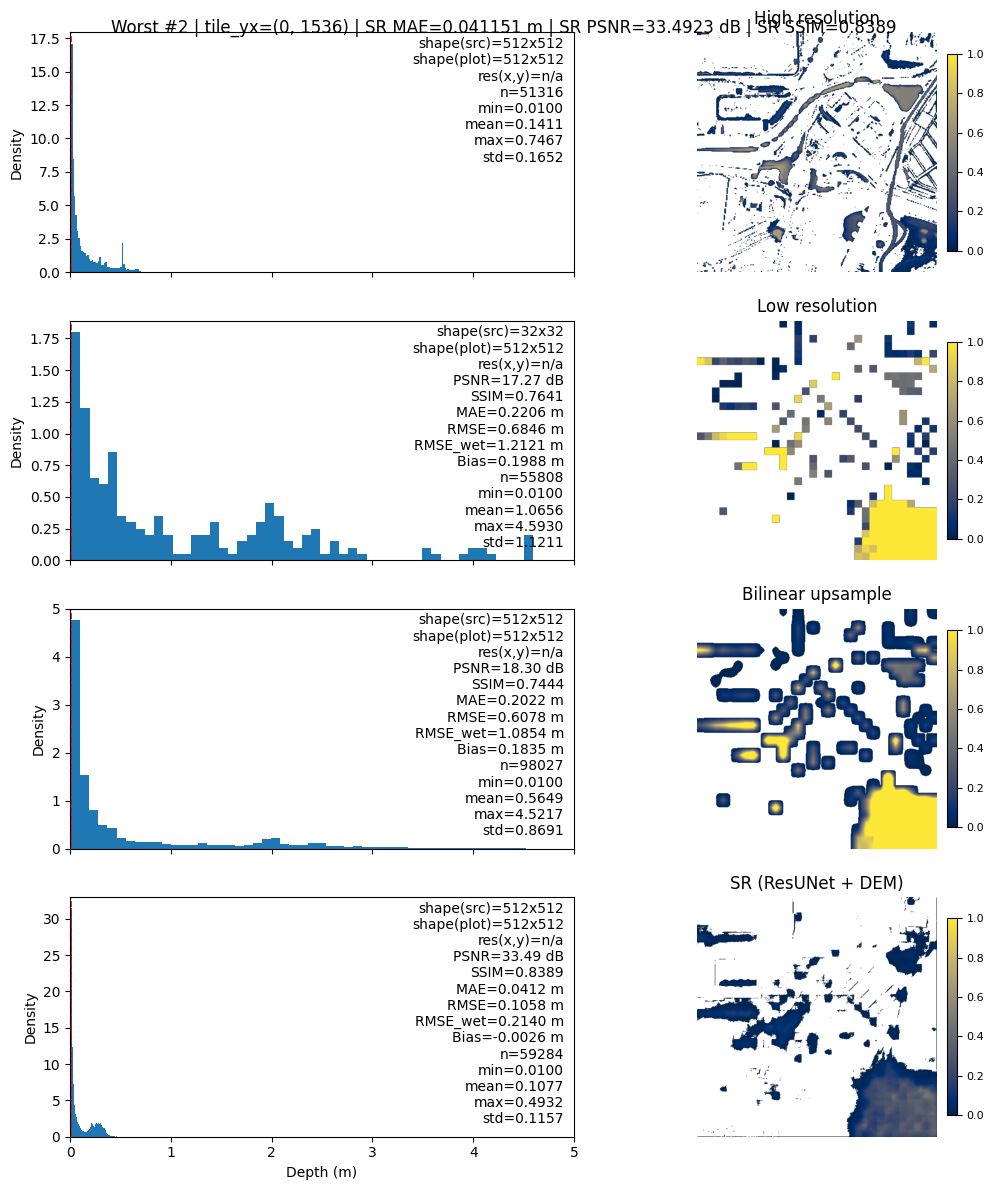

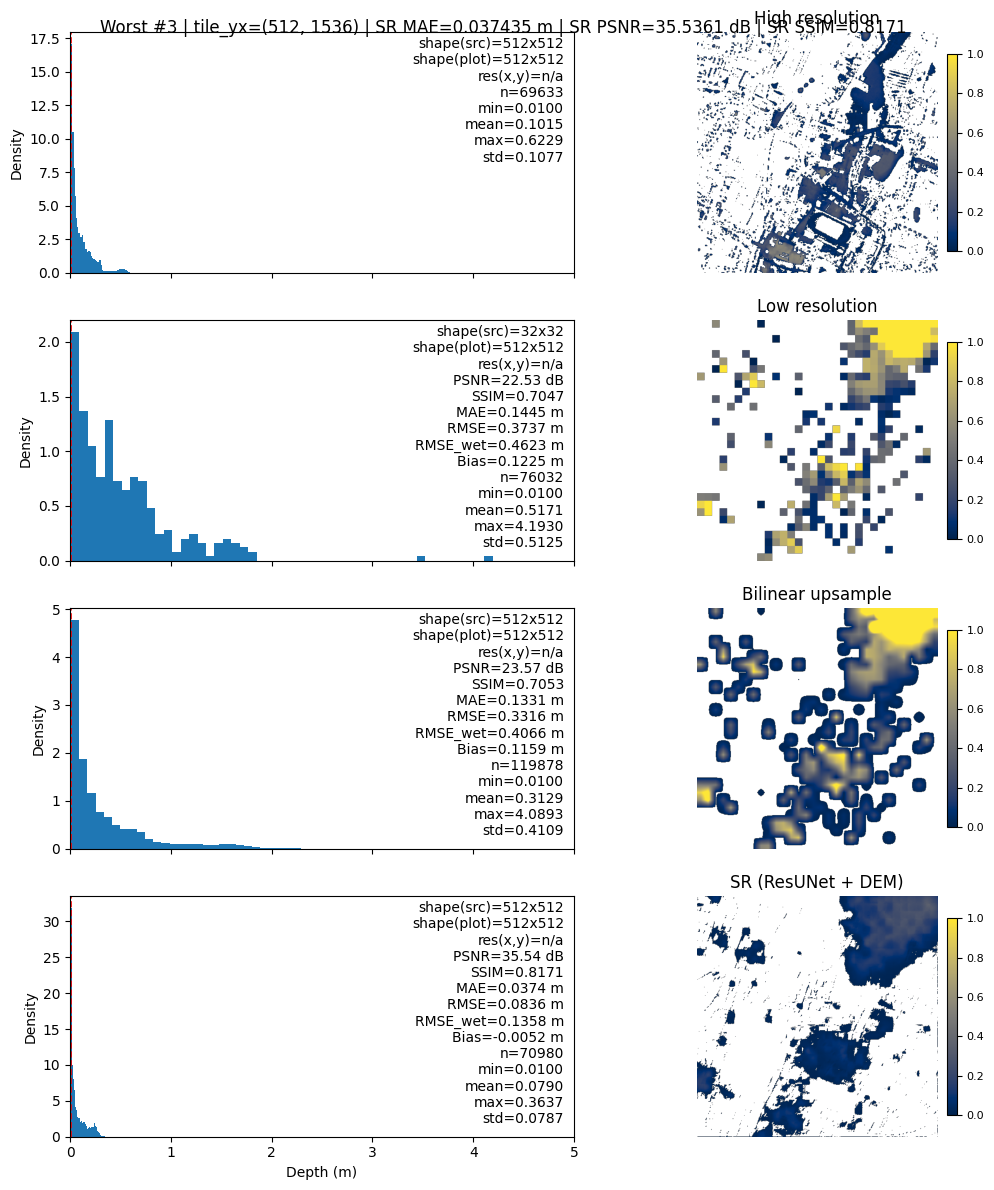


Best chips (lowest SR MAE):


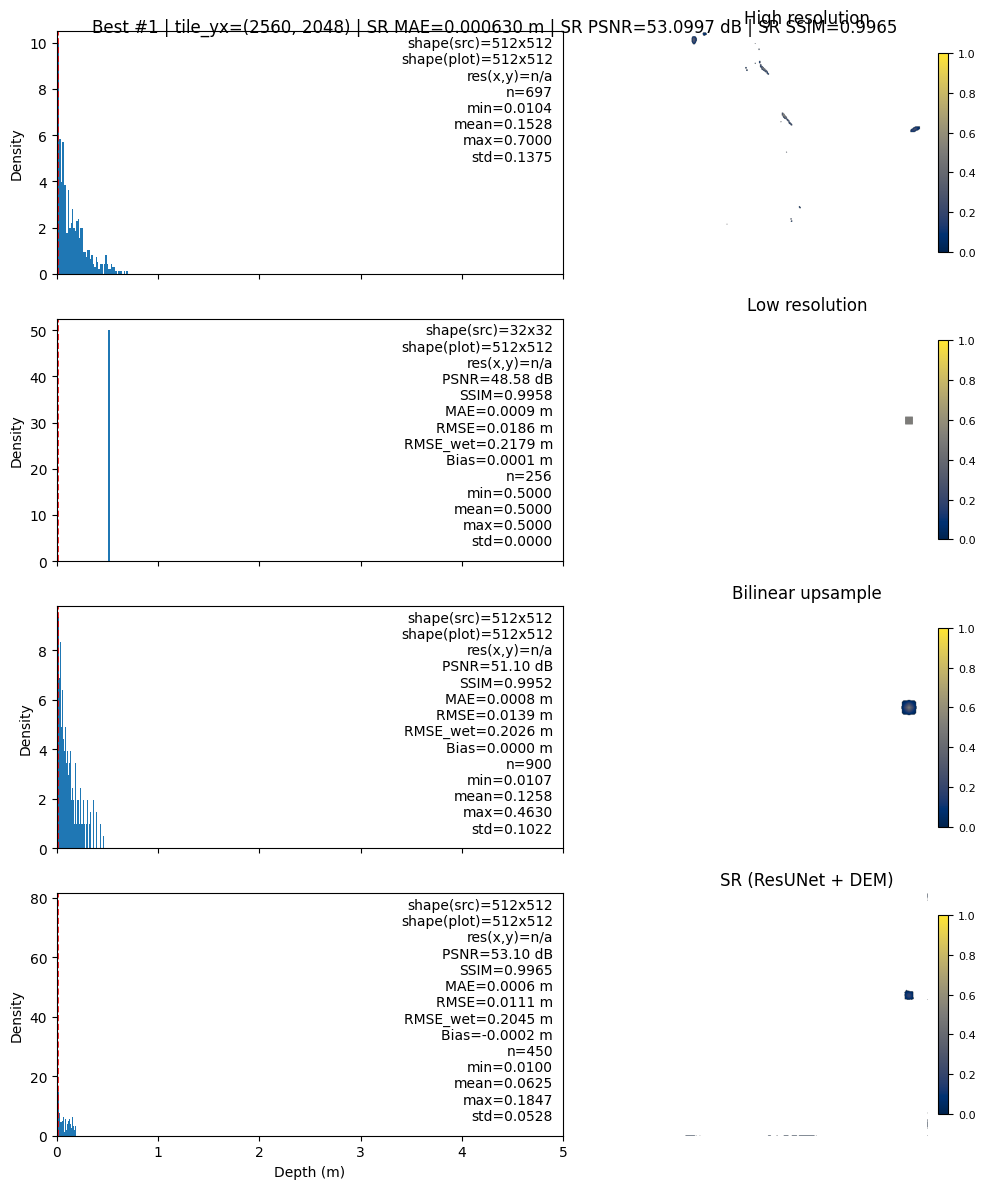

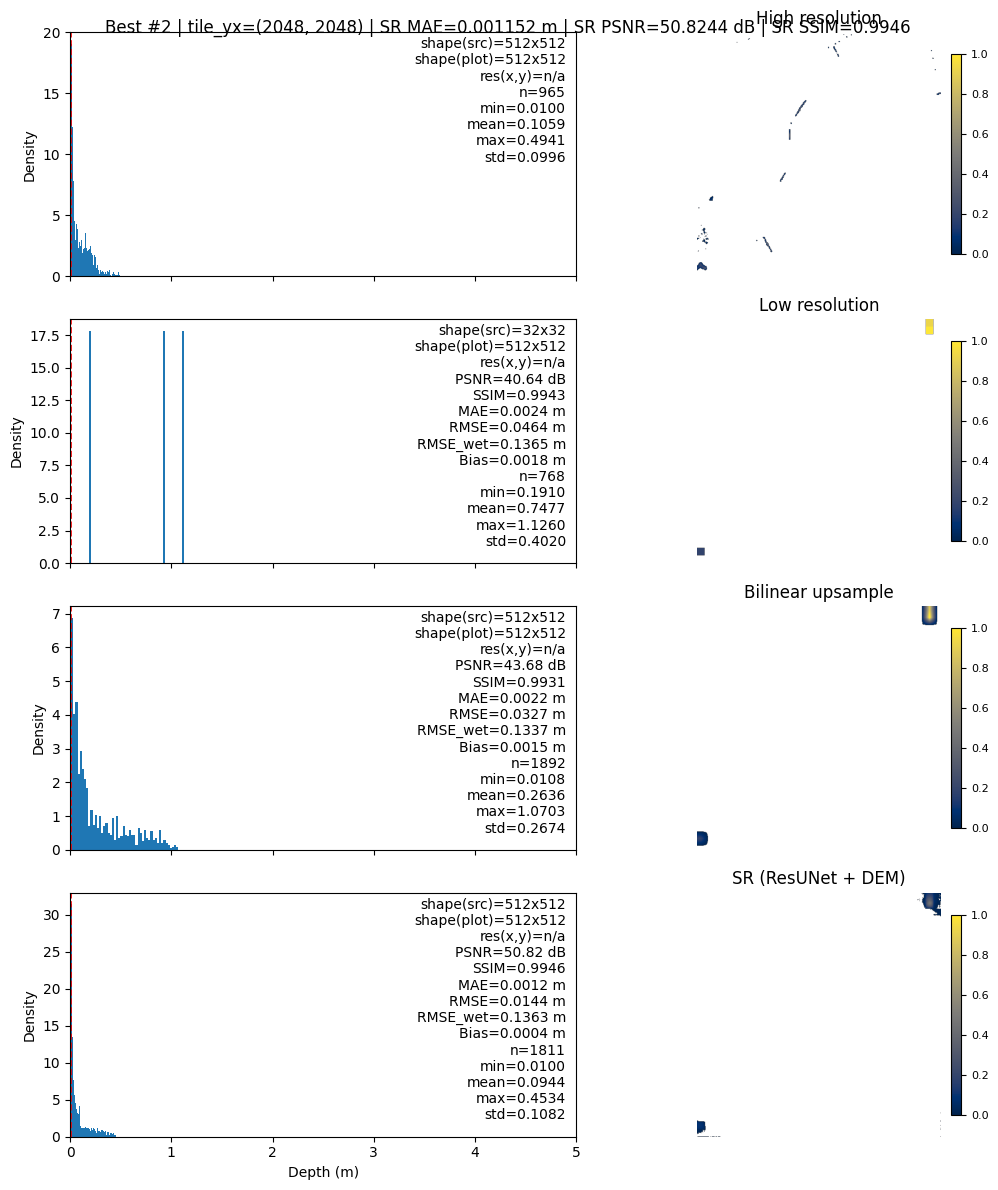

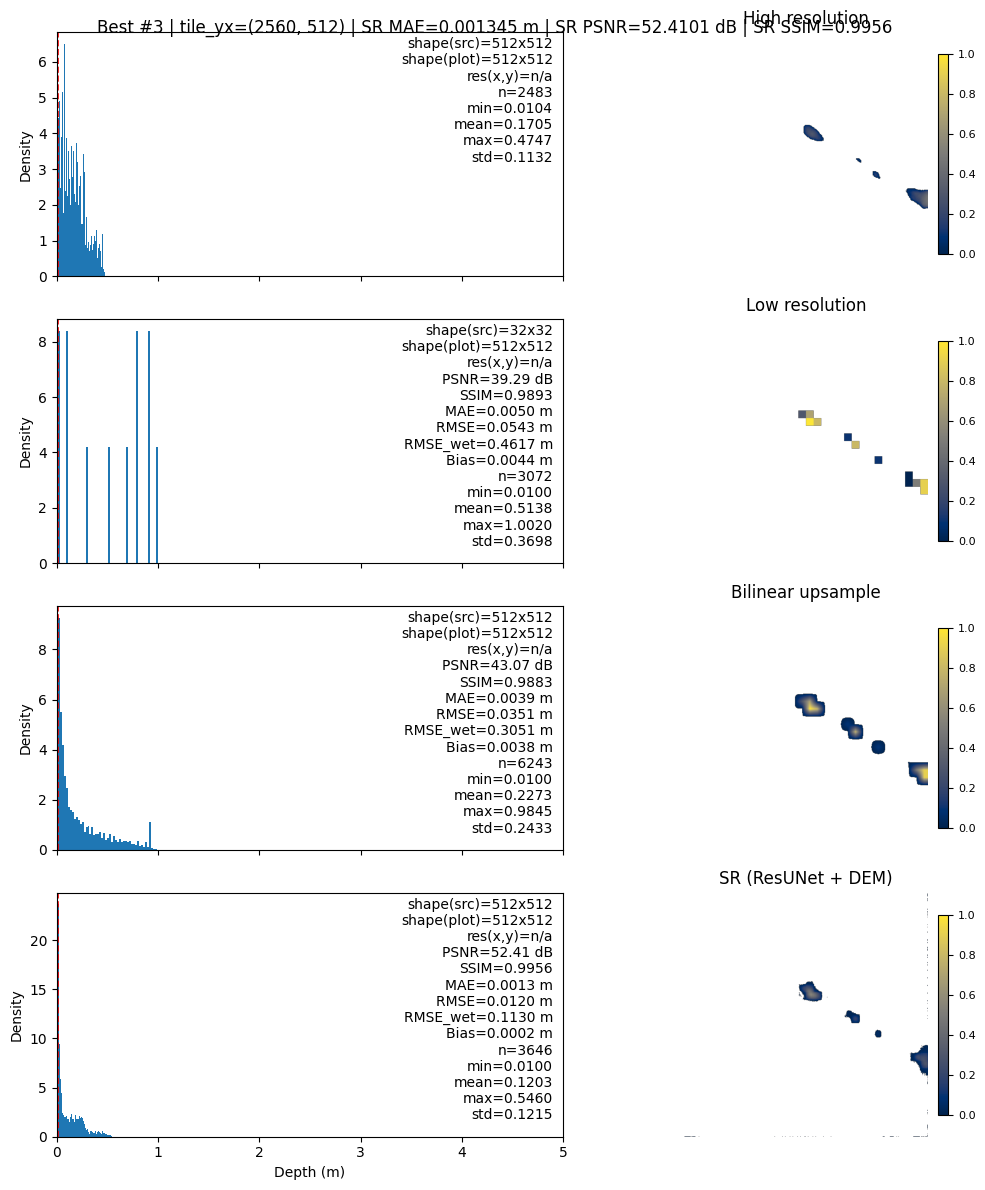

In [25]:
_ = results.plot_best_worst_chip_examples(
    lowres_chips=lowres_chips,
    highres_chips=highres_chips,
    preds_chips=preds_chips,
    max_depth=MAX_DEPTH,
    n_show=3,
    dry_depth_thresh_m=DRY_DEPTH_THRESH_M,
    cmap="cividis",
    chip_ids=chip_coords,
)

## 9) Mosaic-level Inference, Bilinear Comparison, and Export

In [29]:
# Build bilinear baseline on raw HR grid and compare mosaic-level metrics.
lr_norm_eval = np.log1p(np.clip(lr_depth_raw_m, 0.0, MAX_DEPTH)) / DEPTH_LOG_DENOM
lr_norm_eval = np.clip(lr_norm_eval, 0.0, 1.0).astype(np.float32, copy=False)

baseline_shape_scale = (hr_valid.shape[0] / lr_norm_eval.shape[0], hr_valid.shape[1] / lr_norm_eval.shape[1])
baseline_res_scale = (lr_res_raw[0] / hr_res[0], lr_res_raw[1] / hr_res[1])
print("Full-scene bilinear baseline geometry (raw-grid evaluation):")
print("  baseline method (fixed): bilinear")
print(f"  LR raw shape/res: {lr_norm_eval.shape} / ({lr_res_raw[0]:.6g}, {lr_res_raw[1]:.6g})")
print(f"  HR raw shape/res: {hr_valid.shape} / ({hr_res[0]:.6g}, {hr_res[1]:.6g})")
print(f"  scale from shape (h,w): ({baseline_shape_scale[0]:.2f}, {baseline_shape_scale[1]:.2f})")
print(f"  scale from resolution (x,y): ({baseline_res_scale[0]:.2f}, {baseline_res_scale[1]:.2f})")

baseline_tensor = tf.convert_to_tensor(lr_norm_eval[None, ..., None], dtype=tf.float32)
baseline = tf.image.resize(
    baseline_tensor,
    size=raw_hr_shape,
    method="bilinear",
    antialias=True,
)[0, ..., 0].numpy().astype(np.float32, copy=False)
baseline = np.clip(baseline, 0.0, 1.0)
print(f"  bilinear output shape: {baseline.shape}")
print(f"  bilinear output resolution: ({hr_res[0]:.6g}, {hr_res[1]:.6g})")

# Compute normalized-space metrics for SR and bilinear on the full mosaic.
hr_full = tf.convert_to_tensor(hr_valid[None, ..., None], dtype=tf.float32)
sr_full = tf.convert_to_tensor(sr[None, ..., None], dtype=tf.float32)
bl_full = tf.convert_to_tensor(baseline[None, ..., None], dtype=tf.float32)

sr_metric_tensors = results.compute_per_sample_metrics(hr_full, sr_full)
bl_metric_tensors = results.compute_per_sample_metrics(hr_full, bl_full)

metrics_sr = results.reduce_metric_buffers({k: [v] for k, v in sr_metric_tensors.items()})
metrics_bilinear = results.reduce_metric_buffers({k: [v] for k, v in bl_metric_tensors.items()})

df = pd.DataFrame({"ResUNet": metrics_sr, "Bilinear": metrics_bilinear})
df = df.loc[list(results.METRIC_KEYS), ["ResUNet", "Bilinear"]]
df["delta"] = df["ResUNet"] - df["Bilinear"]
print("Mosaic metric summary computed on raw HR grid.")
df.round(4)


Full-scene bilinear baseline geometry (raw-grid evaluation):
  baseline method (fixed): bilinear
  LR raw shape/res: (203, 209) / (30, 30)
  HR raw shape/res: (3248, 3344) / (3, 3)
  scale from shape (h,w): (16.00, 16.00)
  scale from resolution (x,y): (10.00, 10.00)
  bilinear output shape: (3248, 3344)
  bilinear output resolution: (3, 3)
Mosaic metric summary computed on raw HR grid.


ResUNet  Bilinear   delta
MAE              0.0059    0.0145 -0.0086
PSNR            32.0955   24.8302  7.2653
SSIM             0.9067    0.8669  0.0398
RMSE             0.0248    0.0573 -0.0325
RMSE_wet_001cm   0.0848    0.1508 -0.0661
RMSE_wet_050cm      NaN       NaN     NaN
RMSE_wet_100cm      NaN       NaN     NaN
CSI_001cm        0.3097    0.3032  0.0065
CSI_050cm        0.0000    0.0000  0.0000
CSI_100cm        0.0000    0.0000  0.0000

Full-scene inference diagnostics (raw-grid evaluation)


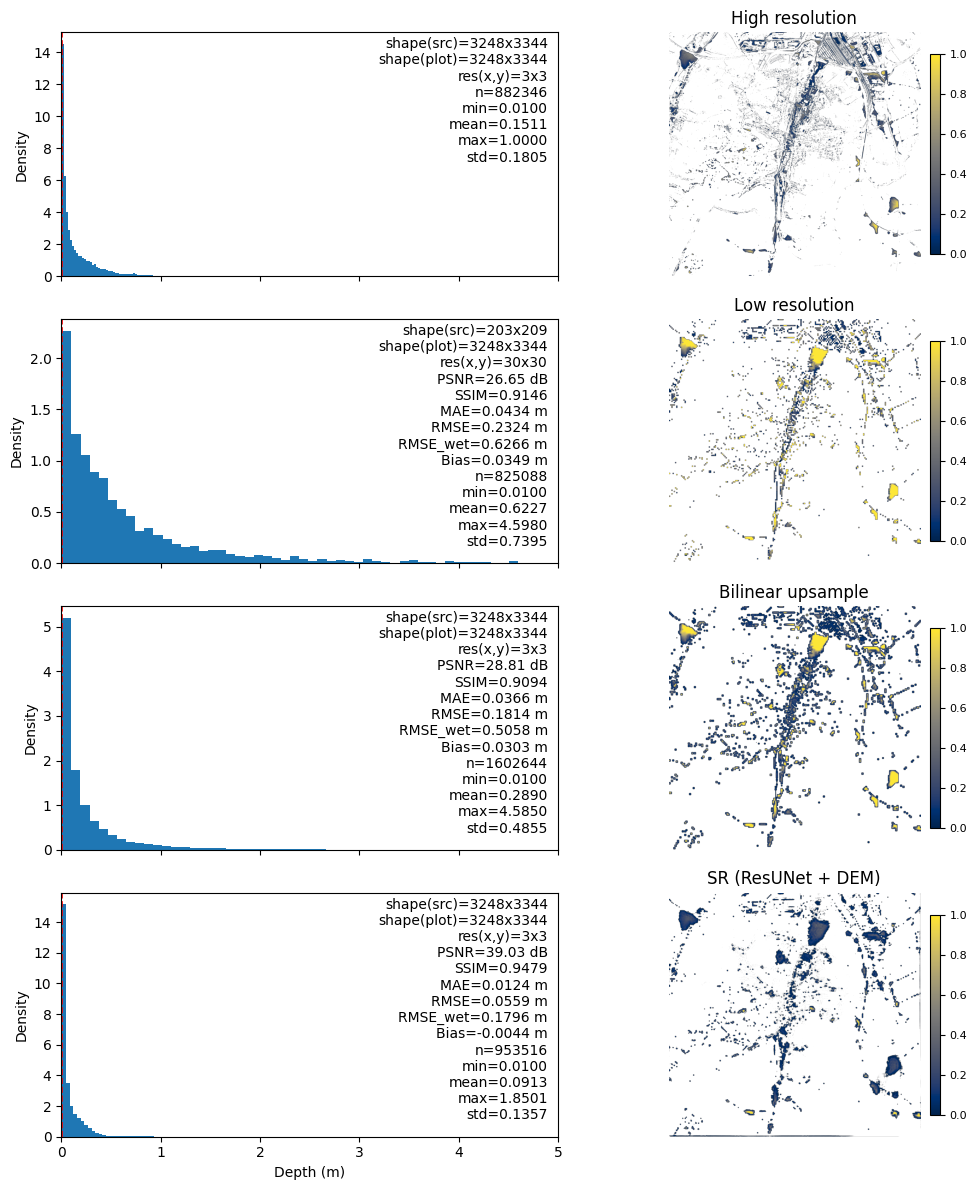

PSNR between LR and HR image full-scene: 26.6534
SSIM between LR and HR image full-scene: 0.9146
PSNR between HR and SR image full-scene: 39.0265
SSIM between HR and SR image full-scene: 0.9479
MAE between HR and SR image full-scene: 0.012357 m


{'lr_psnr': 26.653362274169922,
 'lr_ssim': 0.9145838022232056,
 'lr_mae_m': 0.04336462914943695,
 'lr_rmse_m': 0.2324351817369461,
 'lr_rmse_wet_m': 0.6266283392906189,
 'lr_bias_m': 0.03487890958786011,
 'lr_wet_pixel_count': 882346,
 'lr_dry_pixel_count': 9978966,
 'sr_psnr': 39.0264778137207,
 'sr_ssim': 0.9478932619094849,
 'sr_mae_m': 0.012356706894934177,
 'sr_rmse_m': 0.05593014508485794,
 'sr_rmse_wet_m': 0.17960862815380096,
 'sr_bias_m': -0.004448903724551201,
 'sr_wet_pixel_count': 882346,
 'sr_dry_pixel_count': 9978966,
 'hr_wet_pixel_count': 882346,
 'hr_dry_pixel_count': 9978966,
 'hr_mean_depth_m': 0.012464739382266998,
 'hr_max_depth_m': 1.0,
 'hr_min_depth_m': 0.0,
 'bl_psnr': 28.806163787841797,
 'bl_ssim': 0.9093832969665527,
 'bl_mae_m': 0.036564625799655914,
 'bl_rmse_m': 0.18141023814678192,
 'bl_rmse_wet_m': 0.5058002471923828,
 'bl_bias_m': 0.03031882829964161,
 'bl_wet_pixel_count': 882346,
 'bl_dry_pixel_count': 9978966}

In [30]:
# Plot final mosaic-level comparison diagnostics in depth units.
full_lr = tf.convert_to_tensor(lr_norm_eval[..., None], dtype=tf.float32)
full_hr = tf.convert_to_tensor(hr_valid[..., None], dtype=tf.float32)
full_sr = tf.convert_to_tensor(sr[..., None], dtype=tf.float32)

print("Full-scene inference diagnostics (raw-grid evaluation)")
fig, final_metrics = results.plot_chip_comparison(
    highres=full_hr,
    lowres=full_lr,
    preds=full_sr,
    max_depth=MAX_DEPTH,
    dry_depth_thresh_m=DRY_DEPTH_THRESH_M,
    cmap="cividis",
    lowres_resolution=lr_res_raw,
    highres_resolution=hr_res,
)
plt.show()
plt.close(fig)

tile_label = "full-scene"
print("PSNR between LR and HR image {}: {:.4f}".format(tile_label, final_metrics["lr_psnr"]))
print("SSIM between LR and HR image {}: {:.4f}".format(tile_label, final_metrics["lr_ssim"]))
print("PSNR between HR and SR image {}: {:.4f}".format(tile_label, final_metrics["sr_psnr"]))
print("SSIM between HR and SR image {}: {:.4f}".format(tile_label, final_metrics["sr_ssim"]))
print("MAE between HR and SR image {}: {:.6f} m".format(tile_label, final_metrics["sr_mae_m"]))

final_metrics
